In [7]:
import datetime as dt
from collections import defaultdict, Counter, namedtuple
from itertools import product, combinations, permutations
import json
import os
import pickle
import warnings

from IPython.display import HTML, display, set_matplotlib_formats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sqlalchemy import create_engine
from tqdm.auto import tqdm

# INITIALIZING
# warnings
warnings.filterwarnings('ignore')
# pictures
sns.set()
plt.style.use('seaborn-bright')
plt.rcParams['figure.figsize'] = 10, 6
# pandas
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 100)
tqdm.pandas()

# Autoreload
get_ipython().magic(u"%reload_ext autoreload")
get_ipython().magic(u"%autoreload 2")
get_ipython().magic(u"%load_ext line_profiler")

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [8]:
import re

from glob import glob

from typing import List, Optional

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text

In [11]:
import torch
from transformers import AutoTokenizer, AutoModelForMaskedLM, AutoConfig

### Sampling on patients

In [12]:
PATH = "../data/raw/"
PATH_PROCESSED = "../data/processed/"
PATH_DATASETS = "../data/train/"

In [7]:
SAMPLE_SIZE = 1000
RANDOM_SEED = 1

In [8]:
patients = pd.read_csv(os.path.join(PATH, "PATIENTS.csv.gz"))
patients.EXPIRE_FLAG.value_counts()

0    30761
1    15759
Name: EXPIRE_FLAG, dtype: int64

In [10]:
#ensuring every patient is unique
print(f"{patients.SUBJECT_ID.nunique()} unique patients in {len(patients)} rows")
#sampling random patients
patients_sample = patients  #.sample(n=SAMPLE_SIZE, random_state=RANDOM_SEED)

46520 unique patients in 46520 rows


In [11]:
SAMPLE_IDS = set(patients_sample.SUBJECT_ID)

with open(os.path.join(PATH_PROCESSED, "SAMPLE_IDS.json"), 'w') as f:
    json.dump({'ids': list(SAMPLE_IDS)}, f)
    
with open(os.path.join(PATH_PROCESSED, "SAMPLE_IDS.json"), 'r') as f:
    SAMPLE_IDS = set(json.load(f)['ids'])

In [13]:
patients_sample = patients[patients.SUBJECT_ID.isin(SAMPLE_IDS)]

In [14]:
patients_sample.head()

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,234,249,F,2075-03-13 00:00:00,NaN,NaN,NaN,0
1,235,250,F,2164-12-27 00:00:00,2188-11-22 00:00:00,2188-11-22 00:00:00,NaN,1
2,236,251,M,2090-03-15 00:00:00,NaN,NaN,NaN,0
3,237,252,M,2078-03-06 00:00:00,NaN,NaN,NaN,0
4,238,253,F,2089-11-26 00:00:00,NaN,NaN,NaN,0


In [15]:
DECEASED_TO_DATE = patients_sample[patients_sample.EXPIRE_FLAG == 1]\
    .set_index('SUBJECT_ID').DOD.map(lambda x: pd.to_datetime(x).date()).to_dict()

In [16]:
def get_data_for_sample(sample_ids: set, 
                        file_name: str, 
                        chunksize: int = 10_000) -> pd.DataFrame:
    """Get the data only relevant for the sample."""
    full_path = os.path.join(PATH, file_name)
    iterator = pd.read_csv(full_path, iterator=True, chunksize=chunksize)
    return pd.concat([chunk[chunk.SUBJECT_ID.isin(SAMPLE_IDS)] for chunk in tqdm(iterator)])

### Build features

All features in feature_prepocessed form are features with columns ['SUBJECT_ID', 'FEATURE_NAME', 'DATE', 'VALUE], which can be later used for any of the aggregations we'd like.

In [17]:
admissions = get_data_for_sample(SAMPLE_IDS, "ADMISSIONS.csv.gz")

0it [00:00, ?it/s]

In [18]:
admissions['ADMITTIME'] = pd.to_datetime(admissions.ADMITTIME).dt.date

In [19]:
diagnoses = get_data_for_sample(SAMPLE_IDS, "DIAGNOSES_ICD.csv.gz")

0it [00:00, ?it/s]

In [20]:
lab_results = get_data_for_sample(SAMPLE_IDS, "LABEVENTS.csv.gz", chunksize=100_000)

0it [00:00, ?it/s]

In [21]:
meds = get_data_for_sample(SAMPLE_IDS, "PRESCRIPTIONS.csv.gz")

0it [00:00, ?it/s]

#### Diagnoses

In [22]:
diagnoses['ICD9_CODE'] = "ICD9_" + diagnoses['ICD9_CODE']

In [23]:
adm_cols = ['SUBJECT_ID', 'HADM_ID', 'ADMITTIME']
diagnoses = diagnoses.merge(admissions[adm_cols], on=['SUBJECT_ID', 'HADM_ID'])

In [24]:
dropper = ['ROW_ID', 'SEQ_NUM', 'HADM_ID']
renamer = {'ICD9_CODE': 'FEATURE_NAME', 'ADMITTIME': 'DATE'}
diag_preprocessed = diagnoses.drop(columns=dropper).rename(columns=renamer)
diag_preprocessed['VALUE'] = 1

In [25]:
diag_preprocessed.head()

,SUBJECT_ID,FEATURE_NAME,DATE,VALUE
0,109,ICD9_40301,2141-09-18,1
1,109,ICD9_486,2141-09-18,1
2,109,ICD9_58281,2141-09-18,1
3,109,ICD9_5855,2141-09-18,1
4,109,ICD9_4254,2141-09-18,1


#### Labs

In [26]:
lab_results['DATE'] = pd.to_datetime(lab_results['CHARTTIME']).dt.date

In [27]:
lab_results['FEATURE_NAME'] = "LAB_" + lab_results['ITEMID'].astype(str)

In [29]:
dropper = ['ROW_ID', 'HADM_ID', 'VALUE', 'VALUEUOM', 'FLAG', 'ITEMID', 'CHARTTIME']
renamer = {'VALUENUM': 'VALUE'}
lab_preprocessed = lab_results.drop(columns=dropper).rename(columns=renamer)

In [30]:
lab_preprocessed.head()

,SUBJECT_ID,VALUE,DATE,FEATURE_NAME
0,3,7.39,2101-10-12,LAB_50820
1,3,NaN,2101-10-12,LAB_50800
2,3,-1.00,2101-10-12,LAB_50802
3,3,22.00,2101-10-12,LAB_50804
4,3,0.93,2101-10-12,LAB_50808


#### Meds

In [31]:
meds = meds[meds.ENDDATE.notna()]

In [32]:
meds['DATE'] = pd.to_datetime(meds['ENDDATE']).dt.date

In [33]:
def find_mean_dose(dose: str) -> float:
    if pd.isnull(dose):
        return 0
    try:
        cleaned = re.sub(r'[A-Za-z,>< ]', '', dose)
        parts = cleaned.split('-')
        return np.array(parts).astype(float).mean()
    except:
        print(dose)

In [34]:
meds['VALUE'] = meds['DOSE_VAL_RX'].map(find_mean_dose)

50/500
250/50
500//50
1%
1%
1%
1.25%
800/160
-0.5-2
0.3%
15-30 mmol and Call H.O.
About-CM1000
one
About-CM50
one
one
500/50
4 GM and Call H.O.
standard
2/2.5
12-
4 GM and Call H.O.
'5
0.625/2.5
0.05%
0.05%
-15-30
2mcg/kg
\12.5
15-30 mmol and Call H.O.
16; give 1/2 dose when NPO
7.5mg (3
7.5mg (3
7.5mg (3
7.5mg (3
1%
Hold Dose
5%
1.25/3
-1000
-500
1.36/6
1.26/6
1%
50--100
40-
: 5-10
0.63/3
1-
0.63/3
12.5--25
20-
0.5mg/5
50-
0.5--2
1.26mg/6
1.26mg/6
0.63 mg/3
1.2/1


In [35]:
meds['FEATURE_NAME'] = "MED_" + meds['GSN'].astype(str)

In [36]:
dropper = [col for col in meds.columns if col not in {'SUBJECT_ID', 'DATE', 'FEATURE_NAME', 'VALUE'}]
meds_preprocessed = meds.drop(columns=dropper).rename(columns=renamer)

In [37]:
meds_preprocessed.head()

,SUBJECT_ID,DATE,VALUE,FEATURE_NAME
0,6,2175-06-12,2.0,MED_021796
1,6,2175-06-12,5.0,MED_006562
2,6,2175-06-12,25000.0,MED_006522
3,6,2175-06-12,250.0,MED_nan
4,6,2175-06-12,20.0,MED_008208


#### Notes

Here we can preprocess notes. Later the same things can be done using Spark.

In [38]:
def get_notes(sample_ids: set = None,
              note_path: str = "NOTEEVENTS.csv.gz",
              chunksize: int = 10_000) -> pd.DataFrame:
    """Get all notes or only those relevant for the sample."""
    if sample_ids is None:
        return pd.read_csv(os.path.join(PATH, note_path))
    return get_data_for_sample(sample_ids, note_path, chunksize)

In [39]:
notes = get_notes(SAMPLE_IDS)
# notes.to_csv(os.path.join(PATH_PROCESSED, 'SAMPLE_NOTES.csv'), index=False)

# notes = pd.read_csv(os.path.join(PATH_PROCESSED, 'SAMPLE_NOTES.csv'))

0it [00:00, ?it/s]

In [40]:
notes.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,174,22532,167853.0,2151-08-04,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2151-7-16**] Dischar...
1,175,13702,107527.0,2118-06-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2118-6-2**] Discharg...
2,176,13702,167118.0,2119-05-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2119-5-4**] D...
3,177,13702,196489.0,2124-08-18,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2124-7-21**] ...
4,178,26880,135453.0,2162-03-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2162-3-3**] D...


In [41]:
notes['DATE'] = pd.to_datetime(notes['CHARTDATE']).dt.date

In [42]:
def clean_text(note: str):
    cleaned = re.sub(r'[^\w]', ' ', note).replace("_", " ")
    removed_spaces = re.sub(' +', ' ', cleaned)
    lower = removed_spaces.lower()
    return lower

In [43]:
notes['CLEAN_TEXT'] = notes['TEXT'].map(clean_text)

In [44]:
notes.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT,DATE,CLEAN_TEXT
0,174,22532,167853.0,2151-08-04,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2151-7-16**] Dischar...,2151-08-04,admission date 2151 7 16 discharge date 2151 8...
1,175,13702,107527.0,2118-06-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2118-6-2**] Discharg...,2118-06-14,admission date 2118 6 2 discharge date 2118 6 ...
2,176,13702,167118.0,2119-05-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2119-5-4**] D...,2119-05-25,admission date 2119 5 4 discharge date 2119 5 ...
3,177,13702,196489.0,2124-08-18,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2124-7-21**] ...,2124-08-18,admission date 2124 7 21 discharge date 2124 8...
4,178,26880,135453.0,2162-03-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2162-3-3**] D...,2162-03-25,admission date 2162 3 3 discharge date 2162 3 ...


#### Notes processing
Let's see if we can choose some subparts of notes that will contain more information.

In [45]:
notes.CATEGORY.value_counts()

Nursing/other        822497
Radiology            522279
Nursing              223556
ECG                  209051
Physician            141624
Discharge summary     59652
Echo                  45794
Respiratory           31739
Nutrition              9418
General                8301
Rehab Services         5431
Social Work            2670
Case Management         967
Pharmacy                103
Consult                  98
Name: CATEGORY, dtype: int64

Let's see how how often patients have different kinds of notes

In [46]:
has_note_type = notes.groupby(['SUBJECT_ID', 'CATEGORY']).HADM_ID.count().unstack().fillna(0) > 0

In [47]:
(has_note_type.sum() / has_note_type.shape[0]).sort_values(ascending=False)

CATEGORY
Discharge summary    0.891237
Radiology            0.789841
ECG                  0.740238
Nursing/other        0.648052
Echo                 0.441988
Nursing              0.165518
Physician            0.163958
Respiratory          0.077840
General              0.062389
Nutrition            0.061024
Rehab Services       0.045919
Social Work          0.028757
Case Management      0.012330
Pharmacy             0.001452
Consult              0.001062
dtype: float64

Let's see if having some kind of notes correlates with mortality

In [48]:
has_note_type['DECEASED'] = has_note_type.index.isin(DECEASED_TO_DATE)

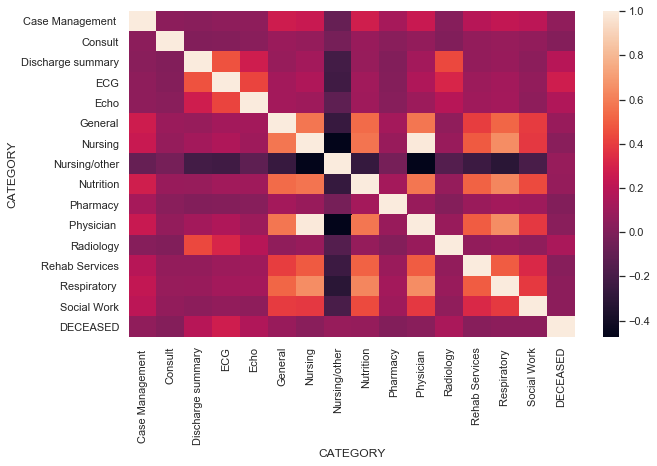

In [49]:
sns.heatmap(has_note_type.corr())

Nothing too severe, let's see last discharge notes for some alive and deceased patients

In [50]:
deceased_notes = notes[(notes.CATEGORY == 'Discharge summary') & notes.SUBJECT_ID.isin(DECEASED_TO_DATE)]

In [51]:
cols_to_use = ['SUBJECT_ID', 'DATE']
for _, row in deceased_notes.sort_values(cols_to_use, ascending=[True, False])\
        .drop_duplicates(cols_to_use).iloc[:3].iterrows():
    pass
#     print(row['TEXT'])
#     print('\n' * 3)

If we print the previous results we see that deceased patients don't have some explicit mention of their death later, so there should not be major data leaks

In [52]:
deceased_notes.TEXT.map(lambda x: 'deceased' in x.lower()).value_counts()

False    23409
True      1618
Name: TEXT, dtype: int64

That helps us to conclude that direct pointers to death can rarely be found in discharge notes

#### Splitting discharge notes into parts

In [53]:
cols_to_use = ['SUBJECT_ID', 'DATE']
discharge_notes = notes[notes.CATEGORY == 'Discharge summary']\
    .sort_values(cols_to_use, ascending=[True, False])\
    .drop_duplicates(cols_to_use)

In [54]:
discharge_notes.SUBJECT_ID.nunique(), discharge_notes.shape[0]

(41127, 55746)

In [55]:
discharge_notes.TEXT.map(lambda x: 'history ' in x.lower()).sum()

52650

Let's try to use only the history part of discharge notes

In [56]:
def prepare_text_for_tokenizer(text: str):
    cleaned = ('. ').join(text.splitlines())
    removed_symbols = re.sub('[\[\]\*\_#:?!]+', ' ', cleaned)
    removed_spaces = re.sub(' +', ' ', removed_symbols)
    removed_dots = re.sub('\. \.| \.', '.', removed_spaces)
    removed_duplicated_dots = re.sub('\.+', '.', removed_dots)
    return removed_duplicated_dots

In [57]:
discharge_notes['TO_TOK'] = discharge_notes.TEXT.map(prepare_text_for_tokenizer)

In [58]:
discharge_notes['HISTORY'] = discharge_notes['TO_TOK'].map(lambda x: x.lower().split('history')[-1])

### Getting clean notes for the whole dataset with pyspark

In [13]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, concat_ws
from pyspark.sql.types import DateType
from pyspark.ml.feature import StopWordsRemover, RegexTokenizer

In [14]:
spark = SparkSession \
    .builder \
    .appName("Note_processing") \
    .getOrCreate()

In [15]:
NOTE_PATH = 'NOTEEVENTS.csv.gz'
FLATTENED = 'NOTESFLATTENED.csv.gz'

In [16]:
# Used for basic preprocessing
# notes = pd.read_csv(os.path.join(PATH, NOTE_PATH))
# notes['TEXT'] = notes.TEXT.map(lambda x: x.replace('\n', ' '))
# notes[['SUBJECT_ID', 'CHARTDATE', 'TEXT']].to_csv(os.path.join(PATH, FLATTENED), index=False)

In [19]:
def clean_text_with_spark(pattern='\w+', gaps=False) -> pd.DataFrame:
    """This is created to iterate fast towards some particular text cleaning strategy."""
    df = spark.read.format("csv") \
        .option("multiline", True) \
        .option("inferSchema", True) \
        .option("header", True) \
        .load(os.path.join(PATH, FLATTENED))
    df = df.na.drop()
    rt = RegexTokenizer(pattern=pattern, gaps=gaps, inputCol='TEXT', outputCol='WORD_ARRAY')
    df = rt.transform(df)
    df = df.withColumn('CLEAN_TEXT', concat_ws(" ", "WORD_ARRAY"))
    drop_cols = ['TEXT', 'WORD_ARRAY']
    df = df.drop(*drop_cols)
    return df.select("*").toPandas()

In [21]:
notes = clean_text_with_spark()

### Feature construction

We need to take into account only the events that happened during the observation window. The end of observation window is N days before death for deceased patients and date of last event for alive patients. We can have several sets of events (e.g. labs, diags, meds), so we need to choose the latest date out of those.

In [59]:
OBSERVATION_WINDOW = 2000
PREDICTION_WINDOW = 50

In [60]:
def define_train_period(*feature_sets, 
                        obs_w: int = OBSERVATION_WINDOW, 
                        pred_w: int = PREDICTION_WINDOW) -> (dict, dict):
    """Create SUBJECT_ID -> earliest_date and SUBJECT_ID -> last date dicts."""
    cols = ['SUBJECT_ID', 'DATE']
    all_feats = pd.concat([feats[cols] for feats in feature_sets])
    last_date_base = all_feats.groupby('SUBJECT_ID').DATE.max().to_dict()
    last_date = {subj_id: date
                 for subj_id, date in last_date_base.items()
                 if subj_id not in DECEASED_TO_DATE}
    subtracted_pred_w = {subj_id: date - dt.timedelta(days=pred_w)
                         for subj_id, date in DECEASED_TO_DATE.items()}
    last_date.update(subtracted_pred_w)
    earliest_date = {subj_id: date - dt.timedelta(days=obs_w)
                     for subj_id, date in last_date.items()}
    return earliest_date, last_date

In [61]:
def clean_up_feature_sets(*feature_sets, earliest_date: dict, last_date: dict) -> list:
    """Leave only features from inside the observation window."""
    results = []
    for feats in feature_sets:
        results.append(feats[(feats.DATE < feats.SUBJECT_ID.map(last_date))
                             & (feats.DATE >= feats.SUBJECT_ID.map(earliest_date))])
    return results

In [62]:
use_feature_sets = [diag_preprocessed, lab_preprocessed, meds_preprocessed]

In [63]:
earliest_date, last_date = define_train_period(*use_feature_sets)

In [64]:
diag, lab, med = clean_up_feature_sets(*use_feature_sets, earliest_date=earliest_date, last_date=last_date)

#### Feat calculations

We are going to do a train test split based on patients to validate our model. We will only use those features that appear in the train set. Also, we will only use features that are shared between many patients (we will define "many" manually for each of the feature sets).  

This way we will lose some patients who don't have "popular" features, but that's fine since our goal is to compare similar patients, not to train the best model.

In [65]:
TRAIN_SIZE = 0.8

In [66]:
TRAIN_IDS, TEST_IDS = train_test_split(list(SAMPLE_IDS), train_size=TRAIN_SIZE, random_state=RANDOM_SEED)

In [67]:
def build_feats(df: pd.DataFrame, agg: list, train_ids: list = None, low_thresh: int = None) -> pd.DataFrame:
    """Build feature aggregations for patient.
    
    Args:
        agg: list of aggregations to use
        train_ids: if not empty, only features that exist in the train set 
            will be used
        low_thresh: if not empty, only features that more than low_thresh
            patients have will be used
    """
    cols_to_use = ['SUBJECT_ID', 'FEATURE_NAME']
    print(f"Total feats: {df.FEATURE_NAME.nunique()}")
    
    if train_ids is not None:
        train_df = df[df.SUBJECT_ID.isin(train_ids)]
        train_feats = set(train_df.FEATURE_NAME)
        df = df[df.FEATURE_NAME.isin(train_feats)]
        print(f"Feats after leaving only train: {len(train_feats)}")
        
    if low_thresh is not None:
        deduplicated = df.drop_duplicates(cols_to_use)
        count = Counter(deduplicated.FEATURE_NAME)
        features_to_leave = set(feat for feat, cnt in count.items() if cnt > low_thresh)
        df = df[df.FEATURE_NAME.isin(features_to_leave)]
        print(f"Feats after removing rare: {len(features_to_leave)}")
    
    grouped = df.groupby(cols_to_use).VALUE.agg(agg)
    return grouped

In [68]:
def pivot_aggregation(df: pd.DataFrame, fill_value = None, use_sparse: bool = True) -> pd.DataFrame:
    """Make sparse pivoted table with SUBJECT_ID as index."""
    pivoted = df.unstack()
    if fill_value is not None:
        pivoted = pivoted.fillna(fill_value)
    
    if use_sparse:
        pivoted = pivoted.astype(pd.SparseDtype("float", fill_value))

    pivoted.columns = [f"{col[-1]}_{col[0]}" for col in pivoted.columns]
    return pivoted

In [69]:
diag_built = build_feats(diag, agg=['count'], train_ids=TRAIN_IDS, low_thresh=30)

Total feats: 6734
Feats after leaving only train: 6399
Feats after removing rare: 1489


In [70]:
diag_final = pivot_aggregation(diag_built, fill_value=0)

In [71]:
diag_final.head()

,ICD9_00845_count,ICD9_0088_count,ICD9_0380_count,ICD9_03811_count,ICD9_03812_count,ICD9_03819_count,ICD9_0382_count,ICD9_0383_count,ICD9_03840_count,ICD9_03842_count,ICD9_03843_count,ICD9_03849_count,ICD9_0388_count,ICD9_0389_count,ICD9_04101_count,ICD9_04102_count,ICD9_04104_count,ICD9_04109_count,ICD9_04110_count,ICD9_04111_count,ICD9_04112_count,ICD9_04119_count,ICD9_0413_count,ICD9_0414_count,ICD9_04149_count,ICD9_0415_count,ICD9_0416_count,ICD9_0417_count,ICD9_04184_count,ICD9_04185_count,ICD9_04186_count,ICD9_04189_count,ICD9_042_count,ICD9_0539_count,ICD9_0549_count,ICD9_07030_count,ICD9_07032_count,ICD9_07044_count,ICD9_07051_count,ICD9_07054_count,ICD9_07070_count,ICD9_07071_count,ICD9_0785_count,ICD9_07999_count,ICD9_1101_count,ICD9_1103_count,ICD9_1120_count,ICD9_1121_count,ICD9_1122_count,ICD9_1123_count,ICD9_1125_count,ICD9_11284_count,ICD9_11289_count,ICD9_1173_count,ICD9_1179_count,ICD9_135_count,ICD9_1363_count,ICD9_138_count,ICD9_1505_count,ICD9_1508_count,ICD9_1510_count,ICD9_1541_count,ICD9_1550_count,ICD9_1551_count,ICD9_1552_count,ICD9_1570_count,ICD9_1578_count,ICD9_1622_count,ICD9_1623_count,ICD9_1625_count,ICD9_1628_count,ICD9_1629_count,ICD9_1748_count,ICD9_1749_count,ICD9_1830_count,...,ICD9_V3101_count,ICD9_V3401_count,ICD9_V420_count,ICD9_V422_count,ICD9_V427_count,ICD9_V4281_count,ICD9_V4282_count,ICD9_V4283_count,ICD9_V433_count,ICD9_V4364_count,ICD9_V4365_count,ICD9_V440_count,ICD9_V441_count,ICD9_V442_count,ICD9_V443_count,ICD9_V444_count,ICD9_V446_count,ICD9_V4501_count,ICD9_V4502_count,ICD9_V451_count,ICD9_V4511_count,ICD9_V452_count,ICD9_V453_count,ICD9_V454_count,ICD9_V4561_count,ICD9_V4571_count,ICD9_V4572_count,ICD9_V4573_count,ICD9_V4577_count,ICD9_V4579_count,ICD9_V4581_count,ICD9_V4582_count,ICD9_V4585_count,ICD9_V4586_count,ICD9_V4588_count,ICD9_V4589_count,ICD9_V4611_count,ICD9_V462_count,ICD9_V463_count,ICD9_V4972_count,ICD9_V4975_count,ICD9_V4976_count,ICD9_V4983_count,ICD9_V4986_count,ICD9_V4987_count,ICD9_V502_count,ICD9_V5331_count,ICD9_V5332_count,ICD9_V550_count,ICD9_V551_count,ICD9_V552_count,ICD9_V553_count,ICD9_V5861_count,ICD9_V5865_count,ICD9_V5866_count,ICD9_V5867_count,ICD9_V5869_count,ICD9_V5883_count,ICD9_V600_count,ICD9_V6284_count,ICD9_V641_count,ICD9_V642_count,ICD9_V643_count,ICD9_V6441_count,ICD9_V667_count,ICD9_V707_count,ICD9_V721_count,ICD9_V850_count,ICD9_V851_count,ICD9_V854_count,ICD9_V8541_count,ICD9_V8542_count,ICD9_V8543_count,ICD9_V8741_count,ICD9_V8801_count
SUBJECT_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0

In [72]:
labs_built = build_feats(lab, agg=['mean', 'max', 'min'], train_ids=TRAIN_IDS, low_thresh=50)

Total feats: 719
Feats after leaving only train: 710
Feats after removing rare: 476


In [73]:
labs_final = pivot_aggregation(labs_built, fill_value=0)

In [74]:
labs_final.head()

,LAB_50800_mean,LAB_50801_mean,LAB_50802_mean,LAB_50803_mean,LAB_50804_mean,LAB_50805_mean,LAB_50806_mean,LAB_50808_mean,LAB_50809_mean,LAB_50810_mean,LAB_50811_mean,LAB_50812_mean,LAB_50813_mean,LAB_50814_mean,LAB_50815_mean,LAB_50816_mean,LAB_50817_mean,LAB_50818_mean,LAB_50819_mean,LAB_50820_mean,LAB_50821_mean,LAB_50822_mean,LAB_50823_mean,LAB_50824_mean,LAB_50825_mean,LAB_50826_mean,LAB_50827_mean,LAB_50828_mean,LAB_50829_mean,LAB_50831_mean,LAB_50835_mean,LAB_50836_mean,LAB_50838_mean,LAB_50841_mean,LAB_50842_mean,LAB_50843_mean,LAB_50849_mean,LAB_50850_mean,LAB_50852_mean,LAB_50853_mean,LAB_50854_mean,LAB_50855_mean,LAB_50856_mean,LAB_50857_mean,LAB_50861_mean,LAB_50862_mean,LAB_50863_mean,LAB_50864_mean,LAB_50866_mean,LAB_50867_mean,LAB_50868_mean,LAB_50871_mean,LAB_50872_mean,LAB_50873_mean,LAB_50874_mean,LAB_50876_mean,LAB_50877_mean,LAB_50878_mean,LAB_50879_mean,LAB_50880_mean,LAB_50881_mean,LAB_50882_mean,LAB_50883_mean,LAB_50884_mean,LAB_50885_mean,LAB_50886_mean,LAB_50887_mean,LAB_50889_mean,LAB_50890_mean,LAB_50891_mean,LAB_50892_mean,LAB_50893_mean,LAB_50895_mean,LAB_50896_mean,LAB_50898_mean,...,LAB_51404_min,LAB_51406_min,LAB_51411_min,LAB_51412_min,LAB_51416_min,LAB_51419_min,LAB_51420_min,LAB_51422_min,LAB_51423_min,LAB_51424_min,LAB_51425_min,LAB_51426_min,LAB_51427_min,LAB_51428_min,LAB_51429_min,LAB_51431_min,LAB_51434_min,LAB_51436_min,LAB_51438_min,LAB_51439_min,LAB_51440_min,LAB_51441_min,LAB_51442_min,LAB_51444_min,LAB_51445_min,LAB_51446_min,LAB_51447_min,LAB_51448_min,LAB_51450_min,LAB_51453_min,LAB_51454_min,LAB_51455_min,LAB_51457_min,LAB_51458_min,LAB_51460_min,LAB_51462_min,LAB_51463_min,LAB_51464_min,LAB_51465_min,LAB_51466_min,LAB_51469_min,LAB_51471_min,LAB_51474_min,LAB_51476_min,LAB_51478_min,LAB_51479_min,LAB_51481_min,LAB_51482_min,LAB_51484_min,LAB_51486_min,LAB_51487_min,LAB_51489_min,LAB_51491_min,LAB_51492_min,LAB_51493_min,LAB_51497_min,LAB_51498_min,LAB_51499_min,LAB_51501_min,LAB_51503_min,LAB_51505_min,LAB_51506_min,LAB_51507_min,LAB_51508_min,LAB_51510_min,LAB_51512_min,LAB_51513_min,LAB_51514_min,LAB_51515_min,LAB_51516_min,LAB_51517_min,LAB_51518_min,LAB_51519_min,LAB_51523_min,LAB_51529_min
SUBJECT_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000,0.0,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.300000,9.000000,9.30,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,530.0,-4.266667,20.0,19.844444,0.0,108.4,1.090417,174.333333,30.173913,10.065217,0.0,2.841176,0.0,0.0,41.785714,82.475,31.6,6.32,7.388958,114.955556,4.246154,85.0,140.222222,37.089286,607.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.000000,2.300000,81.000000,0.0,0.0,35.000000,14.705882,0.0,0.0,0.0,0.0,0.0,0.0,56.000000,0.0,0.0,0.0,22.085714,0.000000,0.000000,0.80,0.0,0.0,0.0,0.0,0.0,0.0,7.925926,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,5.0,500.0,0.0,0.0,1.014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,10.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,-3.000000,0.0,19.500000,0.0,0.0,0.000000,100.000000,32.000000,10.500000,0.0,2.580000,0.0,6.0,40.000000,94.000,27.5,0.00,7.396667,58.000000,0.000000,0.0

In [75]:
meds_built = build_feats(med, agg=['mean', 'count'], train_ids=TRAIN_IDS, low_thresh=50)

Total feats: 4998
Feats after leaving only train: 4806
Feats after removing rare: 1601


In [76]:
meds_final = pivot_aggregation(meds_built, fill_value=0)

In [77]:
meds_final.head()

,MED_000015_mean,MED_000018_mean,MED_000019_mean,MED_000175_mean,MED_000246_mean,MED_000253_mean,MED_000266_mean,MED_000283_mean,MED_000284_mean,MED_000286_mean,MED_000287_mean,MED_000343_mean,MED_000344_mean,MED_000345_mean,MED_000346_mean,MED_000347_mean,MED_000379_mean,MED_000380_mean,MED_000383_mean,MED_000384_mean,MED_000387_mean,MED_000390_mean,MED_000391_mean,MED_000393_mean,MED_000463_mean,MED_000464_mean,MED_000474_mean,MED_000475_mean,MED_000507_mean,MED_000508_mean,MED_000564_mean,MED_000565_mean,MED_000566_mean,MED_000567_mean,MED_000568_mean,MED_000574_mean,MED_000575_mean,MED_000576_mean,MED_000579_mean,MED_000591_mean,MED_000592_mean,MED_000652_mean,MED_000759_mean,MED_000762_mean,MED_001166_mean,MED_001181_mean,MED_001183_mean,MED_001185_mean,MED_001187_mean,MED_001195_mean,MED_001198_mean,MED_001205_mean,MED_001209_mean,MED_001210_mean,MED_001211_mean,MED_001220_mean,MED_001226_mean,MED_001233_mean,MED_001241_mean,MED_001248_mean,MED_001255_mean,MED_001262_mean,MED_001275_mean,MED_001285_mean,MED_001340_mean,MED_001349_mean,MED_001356_mean,MED_001405_mean,MED_001408_mean,MED_001412_mean,MED_001417_mean,MED_001627_mean,MED_001640_mean,MED_001641_mean,MED_001645_mean,...,MED_7894.0_count,MED_7936.0_count,MED_7948.0_count,MED_7993.0_count,MED_8039.0_count,MED_8084.0_count,MED_8148.0_count,MED_8163.0_count,MED_8166.0_count,MED_8171.0_count,MED_8182.0_count,MED_8205.0_count,MED_8207.0_count,MED_8208.0_count,MED_8209.0_count,MED_8210.0_count,MED_8217.0_count,MED_8218.0_count,MED_8220.0_count,MED_8223.0_count,MED_8270.0_count,MED_8334.0_count,MED_8335.0_count,MED_8336.0_count,MED_8348.0_count,MED_8349.0_count,MED_8360.0_count,MED_8398.0_count,MED_8909.0_count,MED_8920.0_count,MED_8921.0_count,MED_8932.0_count,MED_8935.0_count,MED_8937.0_count,MED_8992.0_count,MED_8995.0_count,MED_9043.0_count,MED_9061.0_count,MED_9066.0_count,MED_9156.0_count,MED_9157.0_count,MED_9172.0_count,MED_9218.0_count,MED_9221.0_count,MED_9252.0_count,MED_9263.0_count,MED_9289.0_count,MED_9291.0_count,MED_9294.0_count,MED_9298.0_count,MED_9299.0_count,MED_9310.0_count,MED_9328.0_count,MED_9329.0_count,MED_9331.0_count,MED_9339.0_count,MED_9344.0_count,MED_9361.0_count,MED_9365.0_count,MED_9393.0_count,MED_9394.0_count,MED_9395.0_count,MED_9396.0_count,MED_9477.0_count,MED_9509.0_count,MED_9510.0_count,MED_9537.0_count,MED_9553.0_count,MED_9588.0_count,MED_9592.0_count,MED_9629.0_count,MED_9630.0_count,MED_9700.0_count,MED_9839.0_count,MED_nan_count
SUBJECT_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,250.00,0.0,0.0,0.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

### Model Training

We will use random forest to automatically incorporate feature interrelations into our model.

In [199]:
from sklearn.feature_selection import SelectFromModel
from sklearn.base import clone

In [78]:
def build_df_target(*baseline_feats, feats_to_merge_left: List[pd.DataFrame] = None):
    """Concatenate baseline dataset and left-merge additional features.
    
    All datasets should have SUBJECT_ID as index.
    """
    df_baseline = pd.concat(baseline_feats, axis=1).fillna(0)
    target = pd.Series(df_baseline.index.isin(DECEASED_TO_DATE), index=df_baseline.index, name='target')
    if feats_to_merge_left is None:
        return df_baseline, target
    else:
        merge_feats = pd.concat(feats_to_merge_left, axis=1)
        df_final = df_baseline.merge(merge_feats, left_index=True, right_index=True, how='left').fillna(0)
        return df_final, target

In [172]:
def train_and_predict(df: pd.DataFrame, target: pd.Series, classifier) -> np.array:
    train_loc = df.index.isin(TRAIN_IDS)
    try:
        classifier.fit(df[train_loc], target[train_loc])
        pred = classifier.predict_proba(df[~train_loc])[:, 1]
    except AttributeError:
        classifier.fit(df[train_loc].sparse.to_dense(), target[train_loc])
        pred = classifier.predict_proba(df[~train_loc].sparse.to_dense())[:, 1]
    return pred

In [250]:
def train_and_predict_with_select_feats(df: pd.DataFrame, target: pd.Series, classifier, threshold=-np.inf, max_feats=500) -> np.array:
    """Select top features from the model and retrain the model on those."""
    try:
        df = df.sparse.to_dense()
    except AttributeError:
        pass
    cl_to_retrain = clone(classifier)
    train_loc = df.index.isin(TRAIN_IDS)
    fs = SelectFromModel(classifier, threshold=threshold, max_features=max_feats, prefit=True)
    df_select = fs.transform(df[train_loc])
    print(f"Old shape: {df[train_loc].shape}, transformed shape: {df_select.shape}")
    cl_to_retrain.fit(df_select, target[train_loc])
    df_test = fs.transform(df[~train_loc])
    pred = cl_to_retrain.predict_proba(df_test)[:, 1]
    return pred, cl_to_retrain, df.columns[fs.get_support()]

In [224]:
def show_results(y_true, y_pred_proba, classifier,
                 show_top_feats: Optional[int] = None, 
                 col_names: List[str] = None) -> None:
    """Print ROC-AUC score and possibly top feature importances."""
    print(f"ROC-AUC: {roc_auc_score(y_true, y_pred_proba):.3f}")
    if show_top_feats is not None:
        top_feats = pd.Series(classifier.feature_importances_, index=col_names)\
            .sort_values(ascending=False).iloc[:show_top_feats]
        print()
        print(top_feats)

In [188]:
df, target = build_df_target(diag_final, meds_final, labs_final)

In [189]:
target.value_counts()

False    29631
True      9280
Name: target, dtype: int64

In [190]:
cl = RandomForestClassifier(random_state=RANDOM_SEED)

In [191]:
%%time
pred = train_and_predict(df, target, cl)

CPU times: user 1min 21s, sys: 1.62 s, total: 1min 23s
Wall time: 1min 24s


In [192]:
show_results(target[target.index.isin(TEST_IDS)], pred, cl, show_top_feats=10, col_names=df.columns)

ROC-AUC: 0.884

LAB_51006_mean    0.008716
LAB_51006_max     0.008598
LAB_51277_max     0.007897
LAB_51277_mean    0.007630
LAB_51249_min     0.006224
LAB_50912_mean    0.005992
LAB_51277_min     0.005560
LAB_50912_max     0.005345
LAB_50931_min     0.004884
LAB_51006_min     0.004827
dtype: float64


#### Prediction using top 500 features

In [219]:
%%time
pred, retrained_cl, new_feats = train_and_predict_with_select_feats(df, target, cl)

Old shape: (31165, 6119), transformed shape: (31165, 500)
CPU times: user 39.3 s, sys: 2.61 s, total: 42 s
Wall time: 42.7 s


In [225]:
show_results(target[target.index.isin(TEST_IDS)], pred, retrained_cl, show_top_feats=10, col_names=new_feats)

ROC-AUC: 0.881

LAB_51006_max      0.020538
LAB_51006_mean     0.014755
LAB_51277_max      0.013400
LAB_51277_mean     0.012860
LAB_51277_min      0.010256
LAB_50912_max      0.009337
ICD9_4280_count    0.009314
LAB_51249_min      0.008912
LAB_50931_mean     0.007554
LAB_51006_min      0.007394
dtype: float64


#### Prediction using top features based on selection strategy

In [229]:
%%time
pred, retrained_cl, new_feats = train_and_predict_with_select_feats(df, target, cl, threshold=None, max_feats=None)

Old shape: (31165, 6119), transformed shape: (31165, 953)
CPU times: user 44.2 s, sys: 2.44 s, total: 46.7 s
Wall time: 47.3 s


In [230]:
show_results(target[target.index.isin(TEST_IDS)], pred, retrained_cl, show_top_feats=10, col_names=new_feats)

ROC-AUC: 0.883

LAB_51006_max     0.017249
LAB_51006_mean    0.013202
LAB_51277_max     0.012632
LAB_51277_mean    0.012241
LAB_50912_max     0.008671
LAB_51277_min     0.007905
LAB_50912_mean    0.007659
LAB_51249_min     0.007013
LAB_50931_max     0.006588
LAB_51274_max     0.005999
dtype: float64


### Add note TF-IDF

In [87]:
last_note = clean_up_feature_sets(notes, earliest_date=earliest_date, last_date=last_date)[0]

In [88]:
cols = ['SUBJECT_ID', 'DATE', 'CLEAN_TEXT']
last_note = last_note.sort_values(by=cols, ascending=False).drop_duplicates('SUBJECT_ID')[cols]

In [89]:
last_note.to_pickle('../data/processed/last_note.pkl')

In [90]:
del notes

In [ ]:
import gc
gc.collect()

In [91]:
last_note = last_note[last_note.SUBJECT_ID.isin(SAMPLE_IDS)]

In [92]:
last_note

,SUBJECT_ID,DATE,CLEAN_TEXT
718850,99999,2118-01-01,sicu hpi 63 f pod1 s p plif with respiratory d...
1266755,99995,2147-03-16,2147 3 16 11 24 am cta abd pelvis clip clip n...
92546,99992,2144-07-27,patient test information indication wall motio...
1116220,99991,2185-01-01,2185 1 1 3 02 pm heel axial lateral left clip...
49820,99985,2181-02-12,admission date 2181 1 27 discharge date 2181 2...
...,...,...,...
1674524,7,2121-05-25,npn septic evaluation infant was brought from ...
896528,6,2175-09-04,2175 9 4 7 38 am mra lower ext w w o contrast...
813914,4,2191-06-23,2191 6 23 9 26 am mri abdomen w o w contrast ...
777408,3,2102-04-18,2102 4 18 1 22 pm art dup ext lo uni f u clip...


In [93]:
stop_words = text.ENGLISH_STOP_WORDS
vectorizer = TfidfVectorizer(max_features=200, stop_words=stop_words)
tf_idf = vectorizer.fit_transform(last_note.CLEAN_TEXT)

In [94]:
cols = [f"TFIDF_{feat}" for feat in vectorizer.get_feature_names()]
tf_idf_feats = pd.DataFrame.sparse.from_spmatrix(tf_idf, columns=cols, index=last_note.SUBJECT_ID)

#### Training

In [268]:
df, target = build_df_target(diag_final, meds_final, labs_final, feats_to_merge_left=[tf_idf_feats])

In [269]:
target.value_counts()

False    29631
True      9280
Name: target, dtype: int64

In [270]:
cl = RandomForestClassifier(random_state=RANDOM_SEED)

In [271]:
pred = train_and_predict(df, target, cl)

In [272]:
show_results(target[target.index.isin(TEST_IDS)], pred, cl, show_top_feats=100, col_names=df.columns)

ROC-AUC: 0.896

LAB_51006_max       0.013008
LAB_51006_mean      0.007803
LAB_51277_mean      0.006911
LAB_51249_min       0.006067
LAB_51277_max       0.005876
TFIDF_service       0.005007
LAB_51277_min       0.005004
LAB_50912_max       0.004958
LAB_50931_max       0.004546
LAB_50910_min       0.004249
LAB_51006_min       0.004180
LAB_50912_mean      0.004169
LAB_51256_max       0.004167
LAB_51275_mean      0.004086
LAB_51274_max       0.003979
TFIDF_discharge     0.003953
TFIDF_date          0.003872
LAB_51279_min       0.003855
LAB_50970_max       0.003822
LAB_50912_min       0.003798
LAB_50863_mean      0.003730
LAB_50863_max       0.003716
LAB_51249_mean      0.003558
LAB_51218_max       0.003512
LAB_51218_mean      0.003482
LAB_51222_min       0.003434
TFIDF_diagnosis     0.003366
TFIDF_admitting     0.003294
LAB_50893_mean      0.003281
LAB_51275_max       0.003266
MED_027462_count    0.003257
LAB_51222_mean      0.003238
LAB_51274_min       0.003185
TFIDF_mg            0.00317

Better results, mostly from getting patient discharge information from notes.

#### Prediction using top 500 features

In [236]:
%%time
pred, retrained_cl, new_feats = train_and_predict_with_select_feats(df, target, cl)

Old shape: (31165, 6319), transformed shape: (31165, 500)
CPU times: user 44.5 s, sys: 3.78 s, total: 48.3 s
Wall time: 49.7 s


In [237]:
show_results(target[target.index.isin(TEST_IDS)], pred, retrained_cl, show_top_feats=10, col_names=new_feats)

ROC-AUC: 0.894

LAB_51006_max     0.020105
LAB_51006_mean    0.018432
LAB_51277_max     0.014042
LAB_51277_mean    0.011792
TFIDF_service     0.011593
LAB_50912_max     0.011003
LAB_51249_min     0.008346
LAB_51277_min     0.007501
TFIDF_date        0.007240
LAB_51256_max     0.007001
dtype: float64


#### Prediction using top features based on selection strategy

In [238]:
%%time
pred, retrained_cl, new_feats = train_and_predict_with_select_feats(df, target, cl, threshold=None, max_feats=None)

Old shape: (31165, 6319), transformed shape: (31165, 979)
CPU times: user 49.8 s, sys: 2.75 s, total: 52.6 s
Wall time: 53.4 s


In [239]:
show_results(target[target.index.isin(TEST_IDS)], pred, retrained_cl, show_top_feats=10, col_names=new_feats)

ROC-AUC: 0.900

LAB_51006_max      0.017160
LAB_51006_mean     0.014646
LAB_51277_max      0.010655
TFIDF_discharge    0.009754
LAB_51277_mean     0.009102
TFIDF_service      0.007165
LAB_51249_min      0.007075
LAB_51256_max      0.006914
LAB_50912_max      0.006914
LAB_51277_min      0.006708
dtype: float64


### Add transformer embeddings

In [102]:
LAST_NOTE_EMBEDS_PATH = "../data/embeddings/"

In [103]:
last_note

,SUBJECT_ID,DATE,CLEAN_TEXT
718850,99999,2118-01-01,sicu hpi 63 f pod1 s p plif with respiratory d...
1266755,99995,2147-03-16,2147 3 16 11 24 am cta abd pelvis clip clip n...
92546,99992,2144-07-27,patient test information indication wall motio...
1116220,99991,2185-01-01,2185 1 1 3 02 pm heel axial lateral left clip...
49820,99985,2181-02-12,admission date 2181 1 27 discharge date 2181 2...
...,...,...,...
1674524,7,2121-05-25,npn septic evaluation infant was brought from ...
896528,6,2175-09-04,2175 9 4 7 38 am mra lower ext w w o contrast...
813914,4,2191-06-23,2191 6 23 9 26 am mri abdomen w o w contrast ...
777408,3,2102-04-18,2102 4 18 1 22 pm art dup ext lo uni f u clip...


In [107]:
# prepare_text_for_tokenizer(last_note['TEXT'].iloc[0])

In [108]:
last_note['TO_TOK'] = last_note.CLEAN_TEXT.map(prepare_text_for_tokenizer)

In [109]:
last_note = last_note.reset_index(drop=True)

In [110]:
last_note.head()

,SUBJECT_ID,DATE,CLEAN_TEXT,TO_TOK
0,99999,2118-01-01,sicu hpi 63 f pod1 s p plif with respiratory d...,sicu hpi 63 f pod1 s p plif with respiratory d...
1,99995,2147-03-16,2147 3 16 11 24 am cta abd pelvis clip clip n...,2147 3 16 11 24 am cta abd pelvis clip clip n...
2,99992,2144-07-27,patient test information indication wall motio...,patient test information indication wall motio...
3,99991,2185-01-01,2185 1 1 3 02 pm heel axial lateral left clip...,2185 1 1 3 02 pm heel axial lateral left clip...
4,99985,2181-02-12,admission date 2181 1 27 discharge date 2181 2...,admission date 2181 1 27 discharge date 2181 2...


In [111]:
tokenizer = AutoTokenizer.from_pretrained("deepset/covid_bert_base")

In [112]:
config = AutoConfig.from_pretrained('deepset/covid_bert_base', output_hidden_states=True, output_attentions=True)

In [113]:
model = AutoModelForMaskedLM.from_pretrained("deepset/covid_bert_base", config=config)
model_structure = model.eval()

In [114]:
def get_vector_for_text(text: str, model, tokenizer, max_length: Optional[int] = None) -> torch.Tensor:
    """This can be made faster."""
    encoding = tokenizer(text, 
                         add_special_tokens=True, 
                         truncation=True, 
                         padding="max_length", 
                         return_attention_mask=True, 
                         return_tensors="pt", 
                         max_length=max_length)
    with torch.no_grad():
        outputs = model(**encoding)
        hs = outputs.hidden_states
        token_embeddings = torch.stack(hs, dim=0)
        token_embeddings = torch.squeeze(token_embeddings, dim=1)
        token_embeddings = token_embeddings.permute(1,0,2)
        token_vecs = hs[-2][0]
        text_embedding = torch.mean(token_vecs, dim=0)
        return text_embedding

In [115]:
def calculate_and_store_embeds(path: str, tokenizer, model, df: pd.DataFrame, 
                               text_col: str, embed_id: str = 'SUBJECT_ID', max_length: Optional[int] = None) -> None:
    
    for row_num, row in tqdm(df.iterrows(), 
                             total=df.shape[0]):
        text = row[text_col]
        subj_id = row[embed_id]
        embedding = get_vector_for_text(text, model, tokenizer, max_length=max_length)
        torch.save(embedding, os.path.join(path, f"{subj_id}.pt"))

In [116]:
%%time
sentence = get_vector_for_text(last_note.TO_TOK.iloc[0], model, tokenizer)

CPU times: user 3.23 s, sys: 253 ms, total: 3.48 s
Wall time: 995 ms


In [117]:
calculate_and_store_embeds(LAST_NOTE_EMBEDS_PATH,
                           tokenizer, model,
                           last_note,
                           text_col='TO_TOK')

  0%|          | 0/38214 [00:00<?, ?it/s]

In [118]:
def get_embeds_df(path: str) -> pd.DataFrame:
    subj_ids = []
    embeds = []
    for file in tqdm(glob(path + '*')):
        name = file.split('/')[-1]
        subj_id = int(name.split('.')[0])
        embedding = torch.load(file)
        subj_ids.append(subj_id)
        embeds.append(np.array(embedding))
    embed_df = pd.DataFrame(embeds, index=subj_ids)
    embed_df.columns = [f"EMBED_{i}" for i in embed_df.columns]
    return embed_df

In [119]:
embed_df_cord = get_embeds_df(LAST_NOTE_EMBEDS_PATH)

  0%|          | 0/38214 [00:00<?, ?it/s]

In [120]:
embed_df_cord.head()

,EMBED_0,EMBED_1,EMBED_2,EMBED_3,EMBED_4,EMBED_5,EMBED_6,EMBED_7,EMBED_8,EMBED_9,EMBED_10,EMBED_11,EMBED_12,EMBED_13,EMBED_14,EMBED_15,EMBED_16,EMBED_17,EMBED_18,EMBED_19,EMBED_20,EMBED_21,EMBED_22,EMBED_23,EMBED_24,EMBED_25,EMBED_26,EMBED_27,EMBED_28,EMBED_29,EMBED_30,EMBED_31,EMBED_32,EMBED_33,EMBED_34,EMBED_35,EMBED_36,EMBED_37,EMBED_38,EMBED_39,EMBED_40,EMBED_41,EMBED_42,EMBED_43,EMBED_44,EMBED_45,EMBED_46,EMBED_47,EMBED_48,EMBED_49,EMBED_50,EMBED_51,EMBED_52,EMBED_53,EMBED_54,EMBED_55,EMBED_56,EMBED_57,EMBED_58,EMBED_59,EMBED_60,EMBED_61,EMBED_62,EMBED_63,EMBED_64,EMBED_65,EMBED_66,EMBED_67,EMBED_68,EMBED_69,EMBED_70,EMBED_71,EMBED_72,EMBED_73,EMBED_74,...,EMBED_693,EMBED_694,EMBED_695,EMBED_696,EMBED_697,EMBED_698,EMBED_699,EMBED_700,EMBED_701,EMBED_702,EMBED_703,EMBED_704,EMBED_705,EMBED_706,EMBED_707,EMBED_708,EMBED_709,EMBED_710,EMBED_711,EMBED_712,EMBED_713,EMBED_714,EMBED_715,EMBED_716,EMBED_717,EMBED_718,EMBED_719,EMBED_720,EMBED_721,EMBED_722,EMBED_723,EMBED_724,EMBED_725,EMBED_726,EMBED_727,EMBED_728,EMBED_729,EMBED_730,EMBED_731,EMBED_732,EMBED_733,EMBED_734,EMBED_735,EMBED_736,EMBED_737,EMBED_738,EMBED_739,EMBED_740,EMBED_741,EMBED_742,EMBED_743,EMBED_744,EMBED_745,EMBED_746,EMBED_747,EMBED_748,EMBED_749,EMBED_750,EMBED_751,EMBED_752,EMBED_753,EMBED_754,EMBED_755,EMBED_756,EMBED_757,EMBED_758,EMBED_759,EMBED_760,EMBED_761,EMBED_762,EMBED_763,EMBED_764,EMBED_765,EMBED_766,EMBED_767
71722,-0.199597,0.128276,0.718085,-0.388701,-0.102329,0.167867,0.029645,-0.340557,0.107918,-0.422439,0.273899,-0.099894,-0.046134,-0.381045,0.176543,0.717357,-0.057874,0.002464,-0.113914,0.183621,0.630027,-0.357316,0.291080,0.354838,-0.001738,0.175875,-0.071201,-0.069151,0.142517,-0.114328,0.233246,0.152829,0.109970,-0.527347,0.316943,0.050168,-0.174813,0.018598,-0.063050,-0.246874,-0.049857,-0.081755,0.008914,-0.299153,-0.541124,0.022232,0.144702,0.223001,-0.427878,0.175729,-0.437079,-0.455686,0.011744,-0.188377,-0.098222,0.186742,0.007582,-0.007565,-0.099802,-0.263568,0.166673,0.264614,-0.297953,0.126591,-0.294990,0.034109,-0.291699,0.186357,-0.169276,0.559821,-0.136239,0.065150,0.435436,0.272192,0.122566,...,-0.074757,-0.100806,-0.128544,0.023274,-0.284944,-0.659821,0.027020,0.525081,-0.761540,0.068248,-0.071535,-0.207143,-0.391398,0.365011,-0.041412,-0.347234,0.137552,-0.297956,0.055337,0.616171,-0.387249,0.127927,0.400709,-0.261731,-0.044241,-0.150619,0.193708,0.128232,0.226463,-0.086620,-0.095651,-0.471604,-0.369074,-0.236608,-0.208466,-0.676335,-0.396741,0.048930,-0.177669,-0.209846,-0.297194,-0.242546,0.043388,0.051675,0.110699,-0.286888,0.320427,-0.144408,0.121379,0.426598,-0.109743,-0.043318,0.287685,0.194216,0.350567,0.007508,-0.344494,0.273991,0.323298,0.683664,0.023797,-0.576798,0.000249,-0.021221,-0.588558,-0.190467,0.273815,-0.097742,-0.292752,-0.022243,-0.217447,-0.979703,0.294535,-0.416701,0.165263
82412,-0.468055,0.430632,0.723761,-0.488057,0.030809,0.204566,0.286588,-0.089070,-0.068675,-0.036630,0.107773,-0.220798,-0.264219,-0.279889,-0.175305,0.519388,-0.052233,-0.118592,-0.150916,0.275564,0.715271,-0.157016,0.192690,0.159444,0.211376,0.152046,0.033970,-0.332181,0.054970,0.003761,0.155690,0.253198,0.376423,-0.429835,0.224837,-0.067574,-0.071792,-0.275832,0.122419,-0.173609,-0.457992,-0.161361,-0.088098,-0.041622,-0.774563,0.168907,0.237651,0.141014,-0.585243,-0.089969,-0.441000,-0.412005,0.238198,-0.322015,-0.049432,0.081350,-0.264637,-0.287227,-0.276944,-0.359161,0.062582,0.092121,-0.136310,0.139558,-0.323911,-0.021034,-0.185649,0.255453,-0.063558,0.737593,-0.062536,-0.007713,0.547863,0.469338,0.166559,...,-0.111920,-0.257764,-0.061592,0.127675,-0.116015,-0.591214,-0.203812,0.636429,-0.498779,-0.087474,-0.318900,-0.270757,-0.250299,0.688977,-0.062132,-0.351459,-0.502622,-0.393250,-0.065938,0.630741,-0.412833,-0.060410,0.451292,-0.372684,-0.172211,-0.214286,0.407914,0.042372,0.319015,-0.167069,0.006642,-0.352651,-0.094960,-0.064348,-0.154181,-0.592284,-0.539266,0.355212,0.099570,-0.217730,-0.284940,-0.216200,0.0591

#### Training with embeds

In [240]:
df_cord, target = build_df_target(diag_final, meds_final, labs_final, feats_to_merge_left=[embed_df_cord])

In [241]:
cl = RandomForestClassifier(random_state=RANDOM_SEED)

In [242]:
pred_cord = train_and_predict(df_cord, target, cl)

In [243]:
show_results(target[target.index.isin(TEST_IDS)], pred_cord, cl, show_top_feats=10, col_names=df_cord.columns)

ROC-AUC: 0.874

LAB_51006_mean    0.007615
LAB_51006_max     0.006489
LAB_50912_mean    0.005896
LAB_50912_max     0.005618
LAB_51277_max     0.005458
LAB_51277_mean    0.004777
LAB_50910_min     0.003822
LAB_51256_max     0.003744
LAB_50931_max     0.003520
LAB_51277_min     0.003462
dtype: float64


#### Prediction using top 500 features

In [251]:
%%time
pred, retrained_cl, new_feats = train_and_predict_with_select_feats(df_cord, target, cl)

Old shape: (31165, 6887), transformed shape: (31165, 500)
CPU times: user 1min 13s, sys: 2.59 s, total: 1min 16s
Wall time: 1min 17s


In [252]:
show_results(target[target.index.isin(TEST_IDS)], pred, retrained_cl, show_top_feats=10, col_names=new_feats)

ROC-AUC: 0.871

LAB_51006_max      0.020130
LAB_51006_mean     0.017016
LAB_51277_max      0.010024
LAB_51277_mean     0.009921
ICD9_4280_count    0.008542
LAB_51249_min      0.008096
LAB_50912_max      0.007751
LAB_50912_mean     0.007244
LAB_51277_min      0.006646
LAB_51256_max      0.006426
dtype: float64


#### Prediction using top features based on selection strategy

In [253]:
%%time
pred, retrained_cl, new_feats = train_and_predict_with_select_feats(df_cord, target, cl, threshold=None, max_feats=None)

Old shape: (31165, 6887), transformed shape: (31165, 1255)
CPU times: user 1min 46s, sys: 1.89 s, total: 1min 48s
Wall time: 1min 49s


In [254]:
show_results(target[target.index.isin(TEST_IDS)], pred, retrained_cl, show_top_feats=10, col_names=new_feats)

ROC-AUC: 0.875

LAB_51006_mean     0.012413
LAB_51006_max      0.010281
LAB_50912_max      0.008683
LAB_51277_mean     0.008572
LAB_51277_max      0.007507
ICD9_4280_count    0.007372
LAB_50912_mean     0.007016
LAB_51249_min      0.005519
EMBED_100          0.005501
EMBED_341          0.004595
dtype: float64


### Add transformer embeddings for last discharge note of patients

In [ ]:
DISCHARGE_NOTE_EMBEDS_PATH = "../data/embeddings_discharge_history/"

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("deepset/covid_bert_base")

In [ ]:
config = AutoConfig.from_pretrained('deepset/covid_bert_base', output_hidden_states=True, output_attentions=True)

In [ ]:
model = AutoModelForMaskedLM.from_pretrained("deepset/covid_bert_base", config=config)
model_structure = model.eval()

In [ ]:
calculate_and_store_embeds(DISCHARGE_NOTE_EMBEDS_PATH,
                           tokenizer, model,
                           discharge_notes,
                           text_col='HISTORY')

In [ ]:
embed_df = get_embeds_df(DISCHARGE_NOTE_EMBEDS_PATH)

In [ ]:
embed_df.head()

#### Training with embeds

In [ ]:
df, target = build_df_target(diag_final, meds_final, labs_final, feats_to_merge_left=[embed_df])

In [ ]:
cl = RandomForestClassifier(random_state=RANDOM_SEED)

In [ ]:
pred = train_and_predict(df, target, cl)

In [ ]:
show_results(target[target.index.isin(TEST_IDS)], pred, show_top_feats=10)

### Using bluebert transformer

In [125]:
BLUEBERT_LAST_NOTE_EMBEDS = "../data/embeds_bluebert/"

In [126]:
tokenizer = AutoTokenizer.from_pretrained("bionlp/bluebert_pubmed_uncased_L-24_H-1024_A-16")

In [127]:
config = AutoConfig.from_pretrained("bionlp/bluebert_pubmed_uncased_L-24_H-1024_A-16", output_hidden_states=True, output_attentions=True)

In [128]:
model = AutoModelForMaskedLM.from_pretrained("bionlp/bluebert_pubmed_uncased_L-24_H-1024_A-16", config=config)
model_structure = model.eval()

Some weights of the model checkpoint at bionlp/bluebert_pubmed_uncased_L-24_H-1024_A-16 were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [129]:
%%time
sentence = get_vector_for_text(last_note.TO_TOK.iloc[0], model, tokenizer)

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


CPU times: user 7.72 s, sys: 412 ms, total: 8.13 s
Wall time: 2.11 s


In [130]:
calculate_and_store_embeds(BLUEBERT_LAST_NOTE_EMBEDS,
                           tokenizer, model,
                           last_note,
                           text_col='TO_TOK',
                           max_length=512)

  0%|          | 0/38214 [00:00<?, ?it/s]

In [131]:
embed_df_blue = get_embeds_df(BLUEBERT_LAST_NOTE_EMBEDS)

  0%|          | 0/38214 [00:00<?, ?it/s]

In [132]:
embed_df_blue.head()

,EMBED_0,EMBED_1,EMBED_2,EMBED_3,EMBED_4,EMBED_5,EMBED_6,EMBED_7,EMBED_8,EMBED_9,EMBED_10,EMBED_11,EMBED_12,EMBED_13,EMBED_14,EMBED_15,EMBED_16,EMBED_17,EMBED_18,EMBED_19,EMBED_20,EMBED_21,EMBED_22,EMBED_23,EMBED_24,EMBED_25,EMBED_26,EMBED_27,EMBED_28,EMBED_29,EMBED_30,EMBED_31,EMBED_32,EMBED_33,EMBED_34,EMBED_35,EMBED_36,EMBED_37,EMBED_38,EMBED_39,EMBED_40,EMBED_41,EMBED_42,EMBED_43,EMBED_44,EMBED_45,EMBED_46,EMBED_47,EMBED_48,EMBED_49,EMBED_50,EMBED_51,EMBED_52,EMBED_53,EMBED_54,EMBED_55,EMBED_56,EMBED_57,EMBED_58,EMBED_59,EMBED_60,EMBED_61,EMBED_62,EMBED_63,EMBED_64,EMBED_65,EMBED_66,EMBED_67,EMBED_68,EMBED_69,EMBED_70,EMBED_71,EMBED_72,EMBED_73,EMBED_74,...,EMBED_949,EMBED_950,EMBED_951,EMBED_952,EMBED_953,EMBED_954,EMBED_955,EMBED_956,EMBED_957,EMBED_958,EMBED_959,EMBED_960,EMBED_961,EMBED_962,EMBED_963,EMBED_964,EMBED_965,EMBED_966,EMBED_967,EMBED_968,EMBED_969,EMBED_970,EMBED_971,EMBED_972,EMBED_973,EMBED_974,EMBED_975,EMBED_976,EMBED_977,EMBED_978,EMBED_979,EMBED_980,EMBED_981,EMBED_982,EMBED_983,EMBED_984,EMBED_985,EMBED_986,EMBED_987,EMBED_988,EMBED_989,EMBED_990,EMBED_991,EMBED_992,EMBED_993,EMBED_994,EMBED_995,EMBED_996,EMBED_997,EMBED_998,EMBED_999,EMBED_1000,EMBED_1001,EMBED_1002,EMBED_1003,EMBED_1004,EMBED_1005,EMBED_1006,EMBED_1007,EMBED_1008,EMBED_1009,EMBED_1010,EMBED_1011,EMBED_1012,EMBED_1013,EMBED_1014,EMBED_1015,EMBED_1016,EMBED_1017,EMBED_1018,EMBED_1019,EMBED_1020,EMBED_1021,EMBED_1022,EMBED_1023
71722,0.126159,0.436510,0.242167,0.075487,-0.066005,0.160982,-0.556105,-0.116901,-0.044531,0.035461,0.214184,-0.093669,-0.162777,0.060817,-0.389239,0.424134,0.061676,-0.559476,-0.536042,-0.114947,-0.299029,0.227966,-0.100967,0.503610,-0.265138,0.130300,0.079612,0.032571,0.060839,0.404185,-0.464865,0.062208,0.762042,0.112792,-0.118231,0.356843,0.253962,-0.536314,-0.852881,-0.314916,0.170798,0.377525,-0.221571,0.036960,-0.424111,-0.096845,-0.319887,-0.225143,0.062301,-0.211184,0.151822,-0.172018,0.013553,-0.102084,-0.846182,-0.003040,-0.296922,-0.326186,-0.219615,0.252852,0.241332,0.610302,0.120713,-0.245511,0.081097,-0.132424,0.309821,-0.034169,0.159709,-0.044685,-0.173835,0.019423,0.041678,0.095126,0.110174,...,-0.011611,-0.327034,-0.406547,0.070501,0.385579,0.730299,0.382424,-0.456475,-0.039866,-0.152783,0.322712,-0.294549,0.122282,-0.471311,-0.155821,-0.296040,-0.042809,0.001762,0.217919,-0.202362,0.219308,-0.241887,0.283836,0.076513,0.185603,-0.154774,0.289012,0.320288,0.098252,-0.271678,0.020878,-0.239889,0.288305,-0.439668,-0.521628,-0.134196,0.082636,-0.154364,0.142685,-0.166480,0.039682,-0.016251,-0.346280,0.547977,-0.238038,0.486565,0.517330,-0.068962,-0.133956,-0.096405,0.315044,0.370287,-0.038405,-0.101288,0.495852,0.179552,0.216966,0.062044,0.202901,-0.105785,0.020583,0.565039,-0.219493,-0.198222,0.012717,-0.622802,-0.408033,-0.361794,-0.327248,0.594166,0.363368,0.285408,0.072183,-0.126077,-0.738355
82412,-0.033801,0.239327,0.009834,-0.095445,0.006841,-0.098751,-0.177360,0.085988,0.154912,0.218953,0.286586,0.040244,-0.018348,0.312531,-0.393073,-0.023888,0.086215,-0.580380,-0.324074,-0.162556,-0.497023,0.174009,-0.376378,0.187240,-0.209004,0.117070,0.031478,0.180658,-0.012397,0.207855,-0.577716,-0.091582,0.534677,0.192129,0.041386,0.178551,0.474371,-0.348173,-0.638711,-0.175002,0.064390,0.337212,0.072763,-0.152635,-0.378980,-0.111861,-0.361720,0.041414,0.123014,-0.090510,-0.080031,-0.021958,0.232678,-0.317472,-0.653503,-0.029335,-0.357550,-0.166688,-0.070455,-0.137656,-0.050704,0.462457,0.063943,-0.291309,-0.123869,-0.187115,0.013233,-0.078966,0.336568,-0.066077,-0.484040,-0.096028,-0.145613,0.054264,-0.046829,...,0.037423,-0.408514,-0.472092,0.167567,0.134359,0.600675,0.267510,-0.496247,-0.064671,0.135613,0.261699,-0.292142,-0.016971,-0.419180,-0.211325,-0.314253,-0.184657,0.457590,0.378102,-0.410953,0.082616,0.150130,0.702130,0.234030,0.132476,-0.247872,0.155987,0.332855,-0.181230,-0.129482,-0.037377,-0.182101,0.338332,-0.530658,-0.677319,-0.233210,0.159586,-0.075922,0.189328,-0.204555,0.042659,0.16

#### Training with embeds

In [255]:
df_bb, target = build_df_target(diag_final, meds_final, labs_final, feats_to_merge_left=[embed_df_blue])

In [256]:
cl = RandomForestClassifier(random_state=RANDOM_SEED)

In [257]:
pred_bb = train_and_predict(df_bb, target, cl)

In [260]:
show_results(target[target.index.isin(TEST_IDS)], pred_bb, cl, show_top_feats=10, col_names=df_bb.columns)

ROC-AUC: 0.870

LAB_51006_max      0.008446
LAB_51277_max      0.005858
LAB_51006_mean     0.005770
LAB_51249_min      0.005756
LAB_51277_mean     0.004966
ICD9_4280_count    0.003725
LAB_51222_mean     0.003614
LAB_50931_mean     0.003509
EMBED_327          0.003498
LAB_51277_min      0.003322
dtype: float64


#### Prediction using top 500 features

In [261]:
%%time
pred, retrained_cl, new_feats = train_and_predict_with_select_feats(df_bb, target, cl)

Old shape: (31165, 7143), transformed shape: (31165, 500)
CPU times: user 1min 10s, sys: 2.33 s, total: 1min 12s
Wall time: 1min 13s


In [262]:
show_results(target[target.index.isin(TEST_IDS)], pred, retrained_cl, show_top_feats=10, col_names=new_feats)

ROC-AUC: 0.871

LAB_51006_max      0.021531
LAB_51006_mean     0.012972
LAB_51277_max      0.012598
LAB_51277_mean     0.011942
LAB_51249_min      0.008894
LAB_50912_max      0.008787
LAB_51277_min      0.007462
ICD9_4280_count    0.006659
LAB_51256_max      0.005815
LAB_50910_min      0.005722
dtype: float64


#### Prediction using top features based on selection strategy

In [263]:
%%time
pred, retrained_cl, new_feats = train_and_predict_with_select_feats(df_bb, target, cl, threshold=None, max_feats=None)

Old shape: (31165, 7143), transformed shape: (31165, 1482)
CPU times: user 1min 53s, sys: 3.08 s, total: 1min 56s
Wall time: 1min 58s


In [264]:
show_results(target[target.index.isin(TEST_IDS)], pred, retrained_cl, show_top_feats=10, col_names=new_feats)

ROC-AUC: 0.870

LAB_51006_mean     0.011058
LAB_51277_max      0.008753
LAB_51277_mean     0.008331
LAB_51006_max      0.008295
LAB_50912_mean     0.005241
LAB_51277_min      0.004955
LAB_51249_min      0.004903
ICD9_4280_count    0.004777
LAB_51218_max      0.004645
EMBED_194          0.003879
dtype: float64


### Comparing respiratory diseases and other diseases

In [138]:
acute_diag_codes = [
460, 461, 462, 463, 464, 465, 466
]
other_resp_tract_diag_codes = [
470, 471, 472, 473, 474, 475, 476, 477, 478
]
pneumonia_and_influenza_diag_codes = [
480, 481, 482, 483, 484, 485, 486, 487, 488
]
grp4 = [
490, 491, 492, 493, 494, 495, 496
]
grp5 = [
500, 501, 502, 503, 504, 505, 506, 507, 508
]
grp6 = [
510, 511, 512, 513, 514, 515, 516, 517, 518, 519
]

RESPIRATORY_DIAG_CODES: List[int] = [*acute_diag_codes, *other_resp_tract_diag_codes, *pneumonia_and_influenza_diag_codes, *grp4, *grp5, *grp6]

In [139]:
obs_wind_diags = diag_preprocessed[(diag_preprocessed.DATE < diag_preprocessed.SUBJECT_ID.map(last_date)) & (diag_preprocessed.DATE > diag_preprocessed.SUBJECT_ID.map(earliest_date))]

In [148]:
obs_wind_diags = obs_wind_diags[obs_wind_diags.FEATURE_NAME.notna()]

In [149]:
def is_respiratory(diag: str) -> bool:
    for code in RESPIRATORY_DIAG_CODES:
        if diag.split('_')[-1].startswith(str(code)):
            return True
    return False

In [150]:
respiratory_diags = obs_wind_diags[obs_wind_diags.FEATURE_NAME.map(is_respiratory)]

In [151]:
respiratory_patients = set(respiratory_diags.SUBJECT_ID)

In [152]:
comparison = pd.DataFrame([
    target[target.index.isin(TEST_IDS)].to_list(), 
    list(pred_cord),
    list(pred_bb),
    target[target.index.isin(TEST_IDS)].index.isin(respiratory_patients)
], index=['target', 'cord', 'bb', 'respiratory']).T

In [153]:
comparison[['respiratory', 'target']].value_counts()

respiratory  target
False        False     3990
True         False     1953
             True      1041
False        True       762
dtype: int64

In [154]:
def print_roc_aucs(df: pd.DataFrame):
    print(f"CORD ROC-AUC: {roc_auc_score(df.target.astype(bool), df.cord):.3f}, BlueBERT ROC-AUC: {roc_auc_score(df.target.astype(bool), df.bb):.3f}")

In [155]:
def find_roc_aucs_for_comparison(comparison: pd.DataFrame):
    print("Respiratory:")
    print_roc_aucs(comparison[comparison.respiratory])
    print("Non-respiratory:")
    print_roc_aucs(comparison[~comparison.respiratory])

In [156]:
roc_auc_score(comparison[comparison.respiratory].target.astype(bool), comparison[comparison.respiratory].cord)

0.8256557929793962

In [157]:
find_roc_aucs_for_comparison(comparison)

Respiratory:
CORD ROC-AUC: 0.826, BlueBERT ROC-AUC: 0.820
Non-respiratory:
CORD ROC-AUC: 0.892, BlueBERT ROC-AUC: 0.889
